In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from IPython.display import Markdown as md
plt.style.use('ggplot')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In this project I want to:
1. EDA more of the tweets: look at the co-hashtag tweets
2. see if there is any common hashtags that are interesting
3. use the hashtag as the separation like 'hoax'
4. use the hashtags that say 'hoax' for separation, perform sentiment analysis?
5. conduct the hypothesis test: something like: do both mentions thet hospitalization in the same frequency?
6. remember to create your own bag of words: hospital, icu, somerelated words that are related to hospitalization

here is the first part: EDA and data preprocessing
plot out the frequency of the hasthtags. to look at the co-hashtags we want to create a bigram that encompasses the topics in the correct order, and sort them out based on the frequency. 
this data set already pulled out all hashtags in the tweets, I can just use it. write up codes that lowercase all hashtag and correct for typo. Then select the ones with more

Basic info+ data reading

In [4]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
twitter_path='covid19_tweets.csv'
tweets = pd.read_csv(twitter_path)
tweets['text'][1:10]

1    Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2    @diane3443 @wdunlap @realDonaldTrump Trump nev...
3    @brookbanktv The one gift #COVID19 has give me...
4    25 July : Media Bulletin on Novel #CoronaVirus...
5    #coronavirus #covid19 deaths continue to rise....
6    How #COVID19 Will Change Work in General (and ...
7    You now have to wear face coverings when out s...
8    Praying for good health and recovery of @Chouh...
9    POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...
Name: text, dtype: object

In [5]:
tweets.info()
import warnings
warnings.filterwarnings("ignore")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
user_name           179108 non-null object
user_location       142337 non-null object
user_description    168822 non-null object
user_created        179108 non-null object
user_followers      179108 non-null int64
user_friends        179108 non-null int64
user_favourites     179108 non-null int64
user_verified       179108 non-null bool
date                179108 non-null object
text                179108 non-null object
hashtags            127774 non-null object
source              179031 non-null object
is_retweet          179108 non-null bool
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


plot out hashtags count
#Citation:https://www.kaggle.com/aman2000jaiswal/real-nlp-disaster-tweets

In [6]:
#get our most interesting hashtag
def find_hashtags(text):
    gethashtags = re.findall('#\w*[a-zA-Z]\w*',text)
    return gethashtags

def count_hashtags(text):
    gethashtags = re.findall('#\w*[a-zA-Z]\w*',text)
    return len(gethashtags)

def remove_hashtags(text):
    return re.sub('#\w*[a-zA-Z]\w*','',text)
tweets['hash_count'] = tweets.text.apply(count_hashtags)
tweets['hashtags_def'] = tweets.text.apply(find_hashtags)
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hash_count,hashtags_def
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,0,[]
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0,[]
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,1,[#COVID19]
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,1,[#COVID19]
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,2,"[#CoronaVirusUpdates, #COVID19]"


Text(0, 0.5, 'Rows Count')

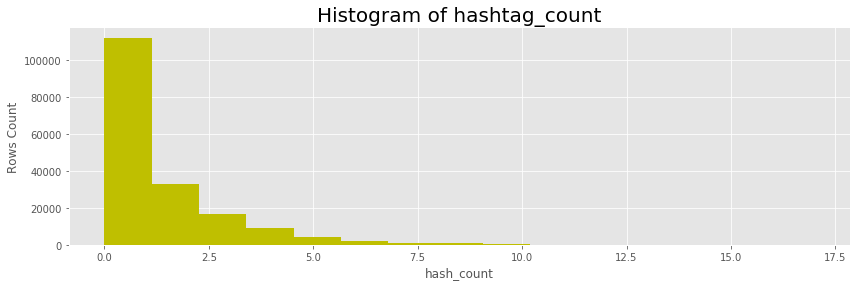

In [7]:
#count average hashtag per tweet
hashtag_count=tweets['hash_count'].value_counts()
hash_count=hashtag_count.sort_index()
hash_count=hash_count.drop(0)
plt.figure(figsize = (14, 4))
plt.title("Histogram of hashtag_count",fontsize=20)
sns.distplot(tweets.hash_count,kde=False,bins=15,hist=True,
                           hist_kws={ "linewidth": 2,
                                     "alpha": 1, "color": "y"})
plt.ylabel("Rows Count")

the raw counts shows lots of tweets have only 1 hashtag, rest more than 2 hashtags: decided to do cohashtag split, and look for the frequency of it for further analysis want to see if we have enough rows that include for than two counts

In [8]:
tweets['hash_count']=tweets['hash_count'].astype(int)
more_than_one=tweets[(tweets.hash_count >= 2)]
len(more_than_one)

67127

pre-process the hasthags to make pairwise co-hashtag
lower case
replace covid

In [9]:
#lower case
tweets['hashTagLower'] = tweets['hashtags'].astype(str).apply(lambda x: x.lower())
tweets.head()
#***add check nans code in all lower

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hash_count,hashtags_def,hashTagLower
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,0,[],nan
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0,[],nan
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,1,[#COVID19],['covid19']
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,1,[#COVID19],['covid19']
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,2,"[#CoronaVirusUpdates, #COVID19]","['coronavirusupdates', 'covid19']"


In [203]:
'''
#citation: 
#covid item
corona_keys = ['covid19','covid_19','covid','pandemic','covid-19','corona','virus','coronavirus','coronavirusupdates']

def hashtag_grouper(a):
    a=str(a)
    b = a.replace("\'","").strip().strip("[").strip("]").lower()
    c = b.split(',')
    for item in c:
        if item in corona_keys:
            return 'covid19'
        else:
            return item
        
tweets['category'] = tweets['hashtags'].apply(hashtag_grouper)
tweets['covid'] = tweets['category'].apply(lambda x: True if x == 'Covid 19' else False)
coronadf = tweets[tweets['covid']>0]
tweets[1:20]'''

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hash_count,hashtags_def,category,covid
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0,[],nan,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,1,[#COVID19],covid19,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,1,[#COVID19],covid19,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,2,"[#CoronaVirusUpdates, #COVID19]",covid19,False
5,🎹 Franz Schubert,Новоро́ссия,🎼 #Новоро́ссия #Novorossiya #оставайсядома #S...,2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Twitter Web App,False,2,"[#coronavirus, #covid19]",covid19,False
6,hr bartender,"Gainesville, FL",Workplace tips and advice served up in a frien...,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,False,2,"[#COVID19, #Recruiting]",covid19,False
7,Derbyshire LPC,NaN,NaN,2012-02-03 18:08:10,608,355,95,False,2020-07-25 12:27:00,You now have to wear face coverings when out s...,NaN,TweetDeck,False,0,[],nan,False
8,Prathamesh Bendre,NaN,"A poet, reiki practitioner and a student of law.",2015-04-25 08:15:41,25,29,18,False,2020-07-25 12:26:59,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",Twitter for Android,False,2,"[#covid19, #covidPositive]",covid19,False
9,Member of Christ 🇨🇳🇺🇸🇮🇳🇮🇩🇧🇷🇳🇬🇧🇩🇷🇺,👇🏻location at link below👇🏻,"Just as the body is one & has many members, & ...",2014-08-17 04:53:22,55201,34239,29802,False,2020-07-25 12:26:54,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,False,2,"[#HurricaneHanna, #COVID19]",hurricanehanna,False
10,Voice Of CBSE Students,NaN,NaN,2020-07-14 17:50:30,8,10,7,False,2020-07-25 12:26:53,49K+ Covid19 cases still no response from \n@c...,NaN,Twitter Web App,False,0,[],nan,False


In [10]:
#text data preprocessing-removing urls and emojis
#cite: https://www.kaggle.com/aman2000jaiswal/real-nlp-disaster-tweets
from nltk import word_tokenize
def remove_urls(sent):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',sent)
def emoji_to_text(sent):
    e_sent = emoji.demojize(sent)
    emo = re.findall(':(.*?):',e_sent)
    for e in emo:
        e_sent = e_sent.replace(':{}:'.format(e),'{}'.format(e))
    return e_sent
# no more hashtags:
def remove_hashtags(text):
    return re.sub('#\w*[a-zA-Z]\w*','',text)
def remove_punctuations(text):
    return re.sub('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?','',text)
def remove_symbols(text):
    return re.sub('[~:*ÛÓ_å¨È$#&%^ª|+-]+?','',text)
def tokenization(text):
    text = re.split('\W+', text)
    return text

In [11]:
tweets_cleaned=tweets
tweets_cleaned['token_text']=tweets_cleaned['text']
tweets_cleaned['text']=tweets_cleaned.text.str.lower()
    #print(tweet_text)
tweets_cleaned['text'] = tweets_cleaned.text.apply(remove_urls)
#print(tweet_text)
tweets_cleaned['text'] = tweets_cleaned.text.apply(emoji_to_text)
    #print(tweet_text)
tweets_cleaned['text'] = tweets_cleaned['text'].apply(remove_hashtags)
    #print(tweet_text)
tweets_cleaned['text'] = tweets_cleaned['text'].apply(remove_punctuations)
    #print(tweet_text)
tweets_cleaned['text'] = tweets_cleaned['text'].apply(remove_symbols)
   # print(tweet_text)
tweets_cleaned['token_text'] = tweets_cleaned['text'].apply(tokenization)

In [12]:
tweets_cleaned.head()
#now join the hashtags
more_than_one=tweets_cleaned[(tweets_cleaned.hash_count >= 2)]
#more_than_one['hashtags_cohashtag']=more_than_one['hashTagLower']
len(more_than_one)

67127

In [240]:
#now create the co-hashtags before splitting into tweets


1     Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2     @diane3443 @wdunlap @realDonaldTrump Trump nev...
3     @brookbanktv The one gift #COVID19 has give me...
4     25 July : Media Bulletin on Novel #CoronaVirus...
5     #coronavirus #covid19 deaths continue to rise....
6     How #COVID19 Will Change Work in General (and ...
7     You now have to wear face coverings when out s...
8     Praying for good health and recovery of @Chouh...
9     POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...
10    49K+ Covid19 cases still no response from \n@c...
11    Order here https//t.co/4NUrGX6EmA\n\n#logo #gr...
12    waving_hand_light_skin_tone@PattyHajdu @Navdee...
13    Let's all protect ourselves from #COVID19.\nIt...
14    Rajasthan Government today started a Plasma Ba...
15    Nagaland police on Covid-19 Awareness at City ...
16    July 25 #COVID19 update\n#TamilNadu - 6988\nDi...
17    Second wave of #COVID19 in Flanders..back to m...
18    It is during our darkest moments that we m

In [14]:
tweets_cleaned['list_hash']=tweets_cleaned['hashTagLower'].apply(tokenization)

l=tweets_cleaned['list_hash'].iloc[16]
l=[i for i in l if i  != '' ]
l
len(l)

3

In [172]:
index = np. arange(5)
index

array([0, 1, 2, 3, 4])

In [13]:
def find_unique_two(index_lengs):
    index_list = np. arange(index_lengs)
    results = []
    for i in range(len(index_list)-1):
        for j in range(i+1, len(index_list)):
            results.append((i,j))
    return results

def create_cohash(tweet_dataset):
    #tweet_dataset['cohashtag']=[]
    for h in range(len(tweet_dataset)-1):
        l=tweets_cleaned['list_hash'].iloc[h]
        l=[i for i in l if i  != '' ]
        tweets_cleaned['list_hash'].iloc[h]=l
        index_len=len(l)
        ind_of_cohash=find_unique_two(index_len)
        temp_cohash_list=[]
        counter=0
        for pair in ind_of_cohash:
            for num in pair:
                counter+=1
                if counter % 2 ==0:
                    temp_cohash='\''+temp_cohash+' , '+l[num]+'\''
                    temp_cohash_list.append(temp_cohash)
                else:
                    temp_cohash=l[num]
        #print(temp_cohash_list)   
        tweet_dataset['cohashtag'].iloc[h]=temp_cohash_list
        #print(tweet_dataset['cohashtag'].iloc[h])
        
    return tweet_dataset

In [15]:
#tweets_sub=tweets_cleaned[1:30]
#tweets_sub['cohashtag']=tweets_sub['hashtags']
tweets_cleaned['cohashtag']=tweets_cleaned['hashtags']
#test=create_cohash(tweets_sub)
#test
#DO NOT EVER RUN THIS COMMAND TWICE
tweets_cohash=create_cohash(tweets_cleaned)
tweets_filtered=tweets_cohash
#test
#test

In [16]:
tweets_filtered=tweets_cohash#backs up cohash dataset
tweets_cohash.head(30)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hash_count,hashtags_def,hashTagLower,token_text,list_hash,cohashtag
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,if i smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,0,[],nan,"[if, i, smelled, the, scent, of, hand, sanitiz...",[nan],[]
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,hey @yankees @yankeespr and @mlb wouldnt it h...,NaN,Twitter for Android,False,0,[],nan,"[hey, yankees, yankeespr, and, mlb, wouldnt, i...",[nan],[]
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realdonaldtrump trump nev...,['COVID19'],Twitter for Android,False,1,[#COVID19],['covid19'],"[, diane3443, wdunlap, realdonaldtrump, trump,...",[covid19],[]
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv the one gift has give me is an a...,['COVID19'],Twitter for iPhone,False,1,[#COVID19],['covid19'],"[, brookbanktv, the, one, gift, has, give, me,...",[covid19],[]
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 july media bulletin on novel \n@kansalro...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,2,"[#CoronaVirusUpdates, #COVID19]","['coronavirusupdates', 'covid19']","[25, july, media, bulletin, on, novel, kansalr...","[coronavirusupdates, covid19]","['coronavirusupdates , covid19']"
5,🎹 Franz Schubert,Новоро́ссия,🎼 #Новоро́ссия #Novorossiya #оставайсядома #S...,2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25 12:27:06,deaths continue to rise its almost as bad a...,"['coronavirus', 'covid19']",Twitter Web App,False,2,"[#coronavirus, #covid19]","['coronavirus', 'covid19']","[, deaths, continue, to, rise, its, almost, as...","[coronavirus, covid19]","['coronavirus , covid19']"
6,hr bartender,"Gainesville, FL",Workplace tips and advice served up in a frien...,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,how will change work in general and recruitin...,"['COVID19', 'Recruiting']",Buffer,False,2,"[#COVID19, #Recruiting]","['covid19', 'recruiting']","[how, will, change, work, in, general, and, re...","[covid19, recruiting]","['covid19 , recruiting']"
7,Derbyshire LPC,NaN,NaN,2012-02-03 18:08:10,608,355,95,False,2020-07-25 12:27:00,you now have to wear face coverings when out s...,NaN,TweetDeck,False,0,[],nan,"[you, now, have, to, wear, face, coverings, wh...",[nan],[]
8,Prathamesh Bendre,NaN,"A poet, reiki practitioner and a student of law.",2015-04-25 08:15:41,25,29,18,False,2020-07-25 12:26:59,praying for good health and recovery of @chouh...,"['covid19', 'covidPositive']",Twitter for Android,False,2,"[#covid19, #covidPositive]","['covid19', 'covidpositive']","[praying, for, good, health, and, recovery, of...","[covid19, covidpositive]","['covid19 , covidpositive']"
9,Member of Christ 🇨🇳🇺🇸🇮🇳🇮🇩🇧🇷🇳🇬🇧🇩🇷🇺,👇🏻location at link below👇🏻,"Just as the body is one & has many members, & ...",2014-08-17 04:53:22,55201,34239,29802,False,2020-07-25 12:26:54,pope as god prophet sadhu sundar selvaraj wat...,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,False,2,"[#HurricaneHanna, #COVID19]","['hurricanehanna', 'covid19']","[pope, as, god, prophet, sadhu, sundar, selvar...","[hurricanehanna, covid19]","['hurricanehanna , covid19']"


In [17]:
#tweets_cohash.head(40)
#tweets_cleaned['cohashtag'].iloc[16]=['covid19, tamilnadu', 'covid19, random']
tweets_cleaned['cohashtag'].iloc[16]

["'covid19 , tamilnadu'", "'covid19 , chennai'", "'tamilnadu , chennai'"]

In [18]:
len(more_than_one)

67127

In [19]:
#now put all cohashtags into the same list
all_cohash=[] #all cohashtags in more than 2 hashtags dataset
more_than_one=tweets_cohash[(tweets_cohash.hash_count >= 2)]
for i in range(len(more_than_one)):
    temp_list=more_than_one['cohashtag'].iloc[i]
    for f in range(len(temp_list)):
        append_cohash=temp_list[f]
        all_cohash.append(append_cohash)

Text(0, 0.5, 'Frequency')

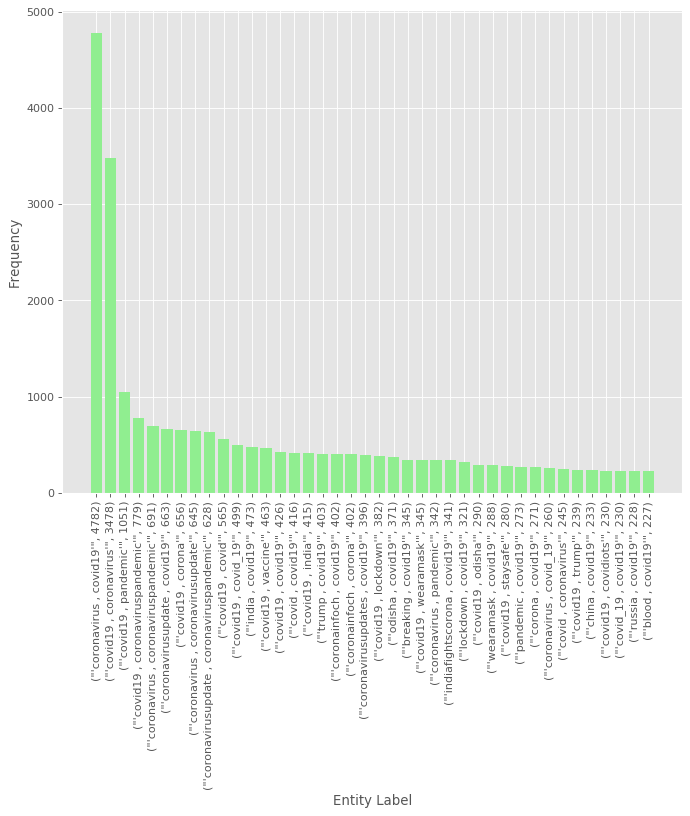

In [20]:
#plot out most common ones:
#import counter
from matplotlib.pyplot import figure
from collections import Counter 
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
res=Counter(all_cohash)
common = Counter(all_cohash).most_common(40)
common
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)
#plt.bar(np.arange(nbars), number, tick_label=labels)
#plt.show()
label=common
label_counter = Counter()
#abel, count = zip(*label_counter.items())
plt.bar(range(len(label)), number,color='lightgreen')
plt.xticks(range(len(label)), label, rotation=90)
plt.xlabel('Entity Label')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

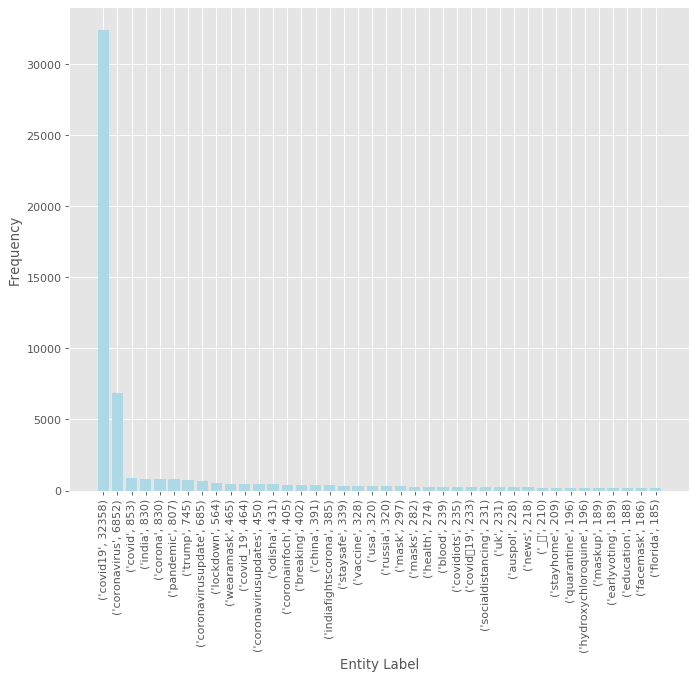

In [21]:
#all_cohash=[] #all cohashtags in more than 2 hashtags dataset
#more_than_one=tweets_cohash[(tweets_cohash.hash_count >= 2)]
#for i in range(len(more_than_one)):
#    temp_list=more_than_one['cohashtag'].iloc[i]
#    for f in range(len(temp_list)):
#        append_cohash=temp_list[f]
#        all_cohash.append(append_cohash)
#instead of cohashtags, look at hashtags

all_hashtags=[] #all hashtags in complete dataset
for i in range(len(tweets_cohash)): 
    temp_list=tweets_cohash['list_hash'].iloc[i]
    for f in range(len(temp_list)-1):
        append_hash=temp_list[f]
        all_hashtags.append(append_hash)
#import counter
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
from collections import Counter 
res=Counter(all_hashtags)
common = Counter(all_hashtags).most_common(40)
common
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)
#plt.bar(np.arange(nbars), number, tick_label=labels)
#plt.show()
label=common
label_counter = Counter()
#abel, count = zip(*label_counter.items())
plt.bar(range(len(label)), number, color='lightblue')
plt.xticks(range(len(label)), label, rotation=90)
plt.xlabel('Entity Label')
plt.ylabel('Frequency')

In [22]:
#NEVER RUN THIS EVER AGAIN THIS TAKES TWO HOURS
from textblob import TextBlob
tweets_cohash['polarity']='to_be_determined'
tweets_cohash['sentiment']=None
for i in range(len(tweets_cohash)-1) :
    blob = TextBlob(tweets_cohash['text'].iloc[i])
    tweets_cohash['polarity'].iloc[i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        tweets_cohash['sentiment'].iloc[i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        tweets_cohash['sentiment'].iloc[i] = 'negative'
    else :
        tweets_cohash['sentiment'].iloc[i] = 'neutral'
tweets_cohash.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,source,is_retweet,hash_count,hashtags_def,hashTagLower,token_text,list_hash,cohashtag,polarity,sentiment
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,if i smelled the scent of hand sanitizers toda...,...,Twitter for iPhone,False,0,[],nan,"[if, i, smelled, the, scent, of, hand, sanitiz...",[nan],[],-0.25,negative
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,hey @yankees @yankeespr and @mlb wouldnt it h...,...,Twitter for Android,False,0,[],nan,"[hey, yankees, yankeespr, and, mlb, wouldnt, i...",[nan],[],0.5,positive
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realdonaldtrump trump nev...,...,Twitter for Android,False,1,[#COVID19],['covid19'],"[, diane3443, wdunlap, realdonaldtrump, trump,...",[covid19],[],0,neutral
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv the one gift has give me is an a...,...,Twitter for iPhone,False,1,[#COVID19],['covid19'],"[, brookbanktv, the, one, gift, has, give, me,...",[covid19],[],0,neutral
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 july media bulletin on novel \n@kansalro...,...,Twitter for Android,False,2,"[#CoronaVirusUpdates, #COVID19]","['coronavirusupdates', 'covid19']","[25, july, media, bulletin, on, novel, kansalr...","[coronavirusupdates, covid19]","['coronavirusupdates , covid19']",0,neutral


two potential key cohashtags: 'covid' and 'vaccine', 'covid' and 'india'

In [23]:
#now store the new data set:
tweets_filtered=tweets_cohash

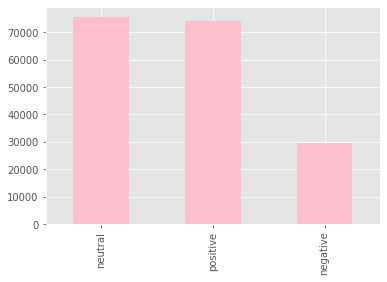

In [151]:
#visualize the sentiment levels:
tweets_cohash['sentiment'].value_counts().plot(kind='bar',color='pink')

In [25]:
all_text=[] #all tokenized text in complete dataset
for i in range(len(tweets_cohash)): 
    temp_list=tweets_cohash['token_text'].iloc[i]
    temp_list=[j for j in temp_list if j  != '' ]
    for f in range(len(temp_list)-1):
        append_text=temp_list[f]
        all_text.append(append_text)

In [130]:
len(more_than_one)

67127

In [93]:
#DO NOT RUN THIS AGAIN AS WELL!!!!!!
from nltk.corpus import stopwords
tok_list=[]
stop_words=stopwords.words('english')
from nltk.stem import PorterStemmer
porter = PorterStemmer()
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
for i in range(len(tweets_cohash)-1):
    tokens=tweets_cohash['token_text'].iloc[i]
    tokens=[j for j in tokens if j  != '' ]
    for token in tokens:
    #print(token)
        if token not in stop_words: #no stop words
            token = lemmatizer.lemmatize(token)
            tok_list.append(token)
    

In [94]:
tok_list

['smelled',
 'scent',
 'hand',
 'sanitizers',
 'today',
 'someone',
 'past',
 'would',
 'think',
 'intoxicated',
 'hey',
 'yankee',
 'yankeespr',
 'mlb',
 'wouldnt',
 'made',
 'sense',
 'player',
 'pay',
 'respect',
 'diane3443',
 'wdunlap',
 'realdonaldtrump',
 'trump',
 'never',
 'claimed',
 'hoax',
 'claim',
 'effort',
 'brookbanktv',
 'one',
 'gift',
 'give',
 'appreciation',
 'simple',
 'thing',
 'always',
 'around',
 '25',
 'july',
 'medium',
 'bulletin',
 'novel',
 'kansalrohit69',
 'drsyedsehrish',
 'airnewsalerts',
 'ani',
 'death',
 'continue',
 'rise',
 'almost',
 'bad',
 'ever',
 'politician',
 'business',
 'want',
 'change',
 'work',
 'general',
 'recruiting',
 'specifically',
 'via',
 'proactivetalent',
 'wear',
 'face',
 'covering',
 'shopping',
 'includes',
 'visit',
 'local',
 'community',
 'pharmacy',
 'praying',
 'good',
 'health',
 'recovery',
 'chouhanshivraj',
 'pope',
 'god',
 'prophet',
 'sadhu',
 'sundar',
 'selvaraj',
 'watch',
 '49k',
 'covid19',
 'case',
 's

In [ ]:
#import counter
figure(num=None, figsize=(13, 8), dpi=80, facecolor='w', edgecolor='k')
from collections import Counter 
res=Counter(tok_list)
common = Counter(tok_list).most_common(70)
common
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)
#plt.bar(np.arange(nbars), number, tick_label=labels)
#plt.show()
label=common
label_counter = Counter()
#abel, count = zip(*label_counter.items())
plt.bar(range(len(label)), number, color='purple')
plt.xticks(range(len(label)), label, rotation=90,fontsize= 11)
plt.xlabel('Entity Label')
plt.ylabel('Frequency')

In [30]:
#split the data into trump related and mask related
tweets_cohash['count_trump']=None
for i in range(len(tweets_cohash)):
    temp_hashtag=tweets_cohash['hashTagLower'].iloc[i]
    #print(temp_hashtag)
    if 'trump' in temp_hashtag:
        #print(i)
        #print(tweets_cohash.iloc[i])
        tweets_cohash['count_trump'].iloc[i]=1
    else:
        tweets_cohash['count_trump'].iloc[i]=0

In [31]:
trump_tweets=tweets_cohash.loc[tweets_cohash['count_trump']==1]

In [131]:
#split the data into trump related and mask related
tweets_cohash['count_mask']=None
for i in range(len(tweets_cohash)):
    temp_hashtag=tweets_cohash['hashTagLower'].iloc[i]
    #print(temp_hashtag)
    if 'mask' in temp_hashtag:
        #print(i)
        #print(tweets_cohash.iloc[i])
        tweets_cohash['count_mask'].iloc[i]=1
    else:
        tweets_cohash['count_mask'].iloc[i]=0
mask_tweets=tweets_cohash.loc[tweets_cohash['count_mask']==1]

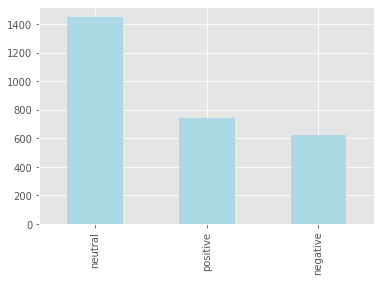

In [33]:
trump_tweets['sentiment'].value_counts().plot(kind='bar',color='lightblue')

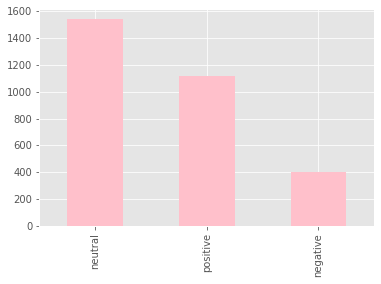

In [132]:
#visualize sentiments in trump tweets and mask tweets
#trump_tweets['sentiment'].value_counts().plot(kind='bar',color='lightblue')
mask_tweets['sentiment'].value_counts().plot(kind='bar',color='pink')

In [143]:
#chi-square test
#contingency table
print(len(mask_tweets))
print(len(trump_tweets))
print(mask_tweets['sentiment'].value_counts()/len(mask_tweets))
print(trump_tweets['sentiment'].value_counts()/len(trump_tweets))
print(mask_tweets['sentiment'].value_counts())
print(trump_tweets['sentiment'].value_counts())

3065
2814
neutral     0.503100
positive    0.365416
negative    0.131485
Name: sentiment, dtype: float64
neutral     0.515281
positive    0.263326
negative    0.221393
Name: sentiment, dtype: float64
neutral     1542
positive    1120
negative     403
Name: sentiment, dtype: int64
neutral     1450
positive     741
negative     623
Name: sentiment, dtype: int64


In [144]:
#import and conduct the test
#count based
from scipy import stats
from scipy.stats import chisquare
obs = np.array([[1542,  1120, 403], [1450,  741, 623]]).T

print(chisquare(obs, axis=None))
chi2_stat, p_val, dof, ex = stats.chi2_contingency(obs)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

Power_divergenceResult(statistic=1095.9443782956284, pvalue=1.0101639660350308e-234)
===Chi2 Stat===
116.68362651233562


===Degrees of Freedom===
2


===P-Value===
4.5969781406425473e-26


===Contingency Table===
[[1559.87072631 1432.12927369]
 [ 970.22707944  890.77292056]
 [ 534.90219425  491.09780575]]


In [51]:
#import and conduct the test
from scipy import stats
from scipy.stats import chisquare
obs = np.array([[0.420403, 0.414904, 0.164687], [0.515281,  0.263326, 0.221393]]).T
print(obs)
obs.shape
print(chisquare(obs))
print(chisquare(obs, axis=None))
print(stats.chi2_contingency(obs))
chi2_stat, p_val, dof, ex = stats.chi2_contingency(obs)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

[[0.420403 0.515281]
 [0.414904 0.263326]
 [0.164687 0.221393]]
Power_divergenceResult(statistic=array([0.12803023, 0.15160986]), pvalue=array([0.93799082, 0.92699702]))
Power_divergenceResult(statistic=0.27964015274245824, pvalue=0.998008556846843)
(0.051825611653097486, 0.974420049655509, 2, array([[0.4678406 , 0.4678434 ],
       [0.33911398, 0.33911602],
       [0.19303942, 0.19304058]]))
===Chi2 Stat===
0.051825611653097486


===Degrees of Freedom===
2


===P-Value===
0.974420049655509


===Contingency Table===
[[0.4678406  0.4678434 ]
 [0.33911398 0.33911602]
 [0.19303942 0.19304058]]


Text(0, 0.5, 'Frequency')

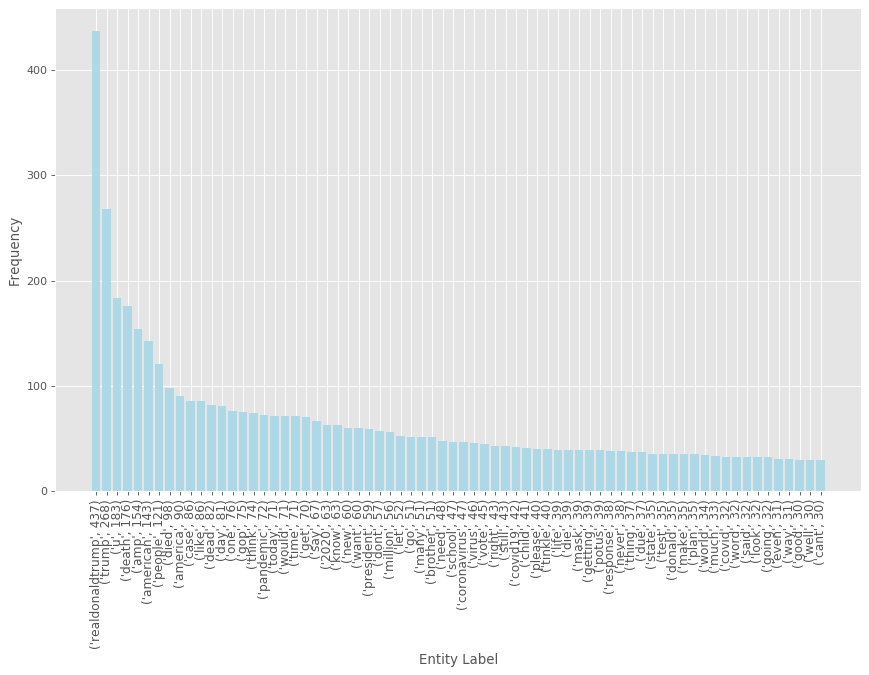

In [97]:
#first calculate the bag of words:

tok_list_t=[]
for i in range(len(trump_tweets)-1):
    tokens=trump_tweets['token_text'].iloc[i]
    tokens=[j for j in tokens if j  != '' ]
    for token in tokens:
    #print(token)
        if token not in stop_words: #no stop words
            token = lemmatizer.lemmatize(token)
            tok_list_t.append(token)
#plot
figure(num=None, figsize=(13, 8), dpi=80, facecolor='w', edgecolor='k')
res=Counter(tok_list_t)
common = Counter(tok_list_t).most_common(70)
common
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)
#plt.bar(np.arange(nbars), number, tick_label=labels)
#plt.show()
label=common
label_counter = Counter()
#abel, count = zip(*label_counter.items())
plt.bar(range(len(label)), number, color='lightblue')
plt.xticks(range(len(label)), label, rotation=90,fontsize= 11)
plt.xlabel('Entity Label')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

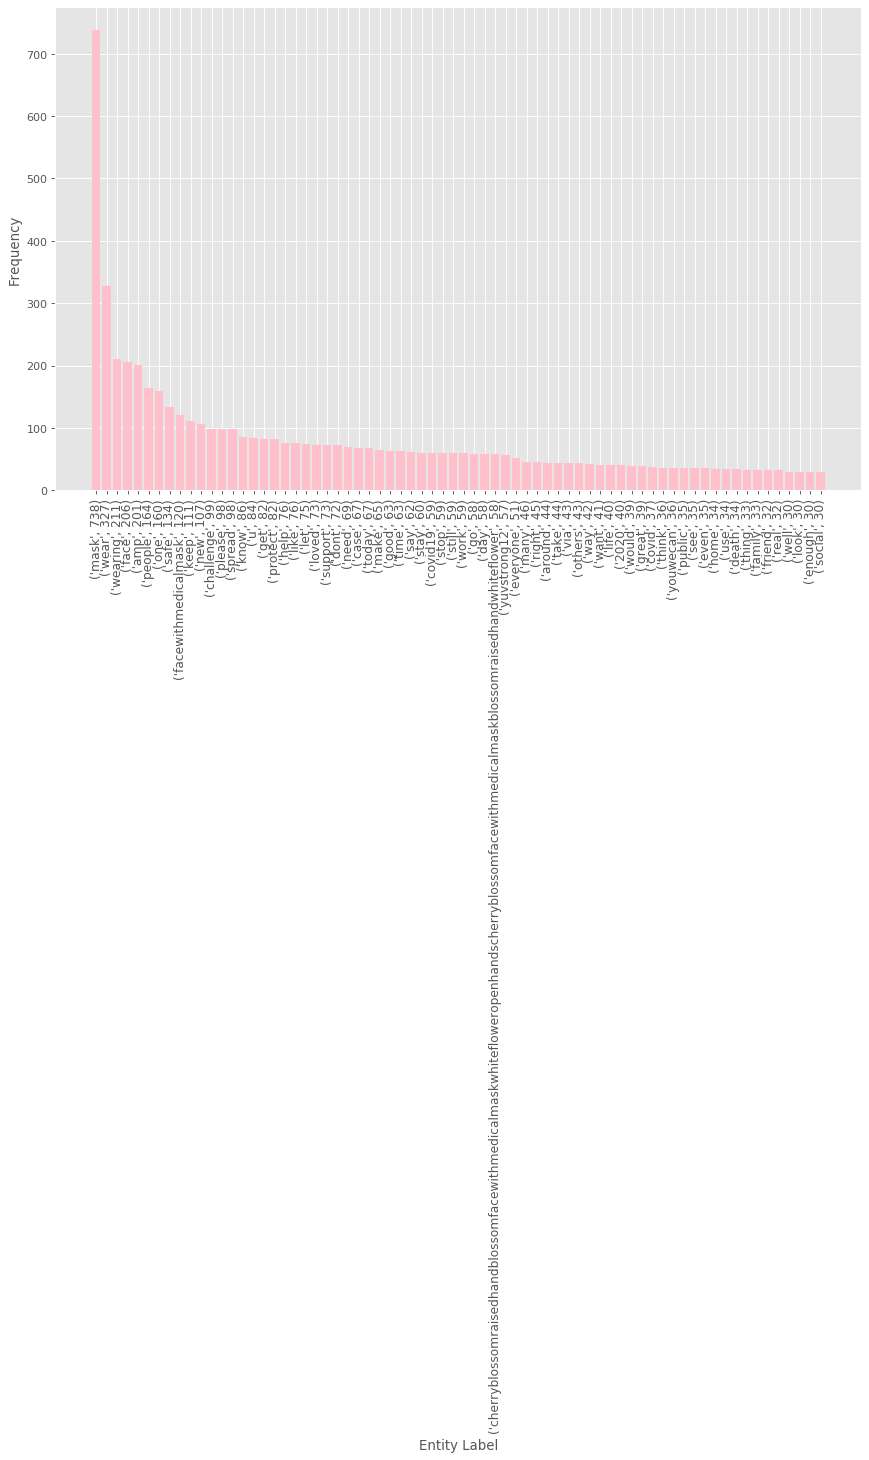

In [133]:
#second bag of words
tok_list_m=[]
for i in range(len(mask_tweets)-1):
    tokens=mask_tweets['token_text'].iloc[i]
    tokens=[j for j in tokens if j  != '' ]
    for token in tokens:
    #print(token)
        if token not in stop_words: #no stop words
            token = lemmatizer.lemmatize(token)
            tok_list_m.append(token)
#plot
figure(num=None, figsize=(13, 8), dpi=80, facecolor='w', edgecolor='k')
res=Counter(tok_list_m)
common = Counter(tok_list_m).most_common(70)
common
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)
#plt.bar(np.arange(nbars), number, tick_label=labels)
#plt.show()
label=common
label_counter = Counter()
#abel, count = zip(*label_counter.items())
plt.bar(range(len(label)), number, color='pink')
plt.xticks(range(len(label)), label, rotation=90,fontsize= 11)
plt.xlabel('Entity Label')
plt.ylabel('Frequency')

In [152]:
tweets_cohash['sentiment'].value_counts()

neutral     75551
positive    74161
negative    29395
Name: sentiment, dtype: int64

In [113]:
#count words
test_count_t=0
test_words=('positive','negative', 'tested','test')
#trump_tweets['count_test']=None
for i in range(len(trump_tweets)-1):
    text=trump_tweets['text'].iloc[i]
    if any(word in text for word in test_words):
        #trump_tweets['count_test'].iloc[i]=1
        test_count_t+=1
    #else:
        #trump_tweets['count_test'].iloc[i]=0

In [145]:
#text1='negativeyayyyyyyyy'
#if any(word in text1 for word in test_words):
    #print('yes')
print(test_count_t/(len(trump_tweets)))
test_count_t

0.03375977256574272


95

In [140]:
test_count_m=0
#test_words=('positive','negative', 'tested','test')
for i in range(len(mask_tweets)-1):
    text=mask_tweets['text'].iloc[i]
    if any(word in text for word in test_words):
        #trump_tweets['count_test'].iloc[i]=1
        test_count_m+=1
    #else:
        #trump_tweets['count_test'].iloc[i]=0

In [141]:
print(test_count_m/len(mask_tweets))
print(test_count_m)
len(mask_tweets)

0.026427406199021206
81


3065

In [128]:
test_count_a=0
#test_words=('positive','negative', 'tested','test')
for i in range(len(tweets_cleaned)-1):
    text=tweets_cleaned['text'].iloc[i]
    if any(word in text for word in test_words):
        #trump_tweets['count_test'].iloc[i]=1
        test_count_a+=1
    #else:
        #trump_tweets['count_test'].iloc[i]=0

In [129]:
print(test_count_a/len(tweets_cleaned))
print(test_count_a)
print(len(tweets_cleaned))

0.08163231123121245
14621
179108


In [149]:
from scipy import stats
from scipy.stats import chisquare
obs = np.array([[0.0264274, 0.033759], [0.029937, 0.029937]]).T
print(obs)
obs.shape
print(chisquare(obs))
print(chisquare(obs, axis=None))
print(stats.chi2_contingency(obs))
chi2_stat, p_val, dof, ex = stats.chi2_contingency(obs)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

[[0.0264274 0.029937 ]
 [0.033759  0.029937 ]]
Power_divergenceResult(statistic=array([0.0008931, 0.       ]), pvalue=array([0.97615897, 1.        ]))
Power_divergenceResult(statistic=0.0008962348191410318, pvalue=0.9999928659728224)
(33.19739985706925, 8.326179267222462e-09, 1, array([[0.02825553, 0.02810887],
       [0.03193087, 0.03176513]]))
===Chi2 Stat===
33.19739985706925


===Degrees of Freedom===
1


===P-Value===
8.326179267222462e-09


===Contingency Table===
[[0.02825553 0.02810887]
 [0.03193087 0.03176513]]


In [154]:
print(tweets_cohash['sentiment'].value_counts()/len(tweets_cohash))
print(tweets_cohash['sentiment'].value_counts())
len(tweets_cohash)

neutral     0.421818
positive    0.414057
negative    0.164119
Name: sentiment, dtype: float64
neutral     75551
positive    74161
negative    29395
Name: sentiment, dtype: int64


179108

----------------------------------splitting line, above are useful codes-------------------------------------------------------

In [95]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
def cleantext(article_text):
  #article_text = tweet_data['text']
  article_text =''.join(str(elem)+' ' for elem in article_text)
  # print("Concatenating all sentences into a string:{}".format(article_text))
  article_text=article_text.lower()
  article_text=re.sub('[,\.!?-]', ' ', article_text)
  #print(article_text)
  corpus = nltk.sent_tokenize(article_text)
  for i in range(len(corpus)):
    corpus [i] = re.sub(r'\W',' ',corpus[i])
    #corpus [i] = re.sub(r'\s+',' ',corpus[i])
  #print(corpus)
  #token appending/join
  tok_list = []
  for sentence in corpus:
      tokens = nltk.word_tokenize(sentence)
      for token in tokens:
        #print(token)
        if token not in stop_words: #no stop words
          token = lemmatizer.lemmatize(token)
          tok_list.append(token)
          #print(token)
  full_sentence=' '.join(tok_list)
  full_sentence=porter.stem(full_sentence)
  return(full_sentence)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qiuxi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
#pull out bigram hashtags that contains vaccine
all_vaccine=[]
for i in range(len(labels)):
    if 'vaccine' in labels[i]:
        all_vaccine.append(labels[i])
all_vaccine
all_lockdown=[]
for i in range(len(labels)):
    if 'lockdown' in labels[i]:
        all_lockdown.append(labels[i])
        print(i)
all_lockdown


19
21


[('covid19', 'lockdown'), ('lockdown', 'covid19')]

In [151]:
#now look at these tweets with the hashtags of vaccine, see if sentiment analysis work on it
vaccine_tweets=more_than_one[(more_than_one['hashtags_bigrams'].astype(str).str.contains('vaccine'))]
lockdown_tweets=more_than_one[(more_than_one['hashtags_bigrams'].astype(str).str.contains('lockdown'))]
trump_tweets=more_than_one[(more_than_one['hashTagLower'].astype(str).str.contains('trump'))]
covidiots_tweets=more_than_one[(more_than_one['hashTagLower'].astype(str).str.contains('covidiots'))]
covidiots_tweets
#for i in range(len(more_than_one)):
  #  if .iloc[i]:
   #     print(more_than_one.iloc[i])
   #     vaccine_tweets.iloc[1]=(more_than_one.iloc[i])

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hash_count,hashtags_def,hashTagLower,hashtags_bigrams
125,Covid and Yossarian,NaN,"A strip about Covid that is funny, smart and h...",2020-05-12 12:56:56,7,0,4,False,2020-07-25 12:23:32,The worst type of spread. #COVID19 #COVIDー19 #...,"['COVID19', 'COVIDー19', 'COVIDIOTS']",Twitter Web App,False,3,"[#COVID19, #COVIDー19, #COVIDIOTS]","['covid19', 'covidー19', 'covidiots']","[(covid19, covidー19), (covidー19, covidiots)]"
981,wayne,"South West, England",Ex-Criminal Law. Police St Rep. Grumpy c*nt. W...,2014-03-01 19:15:42,807,986,18243,False,2020-07-25 11:59:11,Went for a run. Saw a #facemask blowing around...,"['facemask', 'covidiots']",Twitter Web App,False,2,"[#facemask, #covidiots]","['facemask', 'covidiots']","[(facemask, covidiots)]"
1160,Mariano Mos,Switzerland,Argentinean and swiss\nI am about to become ho...,2011-12-26 19:25:38,7118,7486,5,False,2020-07-25 11:52:54,#Covid_19 #COVID19 #covid #COVIDIOTS the head ...,"['Covid_19', 'COVID19', 'covid', 'COVIDIOTS']",Twitter Web App,False,4,"[#Covid_19, #COVID19, #covid, #COVIDIOTS]","['covid_19', 'covid19', 'covid', 'covidiots']","[(covid_19, covid19), (covid19, covid), (covid..."
1208,Mariano Mos,Switzerland,Argentinean and swiss\nI am about to become ho...,2011-12-26 19:25:38,7118,7486,5,False,2020-07-25 11:51:28,#Covid_19 #COVID19 #covid #COVIDIOTS the head ...,"['Covid_19', 'COVID19', 'covid', 'COVIDIOTS']",Twitter Web App,False,4,"[#Covid_19, #COVID19, #covid, #COVIDIOTS]","['covid_19', 'covid19', 'covid', 'covidiots']","[(covid_19, covid19), (covid19, covid), (covid..."
2644,Lornaland,"London, UK",London lady 💋 Chihuahua mum 🐕 Ibiza lover 💃🏼 f...,2010-10-05 14:07:00,132,151,1187,False,2020-07-25 10:54:09,Probably the best thread I’ve ever read. This ...,"['wakeup', 'COVID19', 'COVIDIOTS', 'nomasks', ...",Twitter for iPhone,False,5,"[#wakeup, #COVID19, #COVIDIOTS, #nomasks, #The...","['wakeup', 'covid19', 'covidiots', 'nomasks', ...","[(wakeup, covid19), (covid19, covidiots), (cov..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177826,1964,"Texas, USA","Spaniard. Born in Badajoz, raised in Tenerife...",2015-10-09 23:30:49,658,1248,17728,False,2020-08-29 20:59:03,#COVID19\n#COVIDIOTS\n\nWhy now correcting fig...,"['COVID19', 'COVIDIOTS']",Twitter for Android,False,2,"[#COVID19, #COVIDIOTS]","['covid19', 'covidiots']","[(covid19, covidiots)]"
178057,Sean Fernando,Washington DC,🇱🇰 🇨🇦🇺🇸. Realtor; Banker; Entrepreneur; Consul...,2009-01-22 21:04:35,140,417,88,False,2020-08-29 20:45:41,Well damn... keep those online virtual classes...,"['COVIDIOTS', 'COVID19', 'itsnotover', 'sendtr...",Twitter for iPhone,False,4,"[#COVIDIOTS, #COVID19, #itsnotover, #sendtrump...","['covidiots', 'covid19', 'itsnotover', 'sendtr...","[(covidiots, covid19), (covid19, itsnotover), ..."
178726,Manbear,NaN,"I am on NO side. I am the middle voice, disgus...",2011-12-09 23:32:20,45,99,1595,False,2020-08-29 20:04:45,What the media and twitter sheep will never te...,"['MasksOff', 'COVID19', 'COVIDIOTS', 'COVID']",Twitter for Android,False,4,"[#MasksOff, #COVID19, #COVIDIOTS, #COVID]","['masksoff', 'covid19', 'covidiots', 'covid']","[(masksoff, covid19), (covid19, covidiots), (c..."
178907,Korri Clementson,"Pembroke Pines, FL",NaN,2018-02-21 04:09:39,76,1062,1067,False,2020-08-29 19:56:14,When will we talk about the REAL Pandemic? #mi...,"['missingchild', 'COVID', 'COVID19', 'COVIDIOT...",Twitter for iPhone,False,6,"[#missingchild, #COVID, #COVID19, #COVIDIOTS, ...","['missingchild', 'covid', 'covid19', 'covidiot...","[(missingchild, covid), (covid, covid19), (cov..."


In [152]:
trump_tweets

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hash_count,hashtags_def,hashTagLower,hashtags_bigrams
103,Thomas Faires,"Toronto, Ontario, Canada","...yup, still a husband, vegetarian, computer ...",2011-04-14 12:36:09,738,143,28004,False,2020-07-25 12:24:10,1.28% of the U.S. population is infected with ...,"['COVID19', 'TrumpVirus', 'MaskItOrCasket']",Twitter for iPhone,False,3,"[#COVID19, #TrumpVirus, #MaskItOrCasket]","['covid19', 'trumpvirus', 'maskitorcasket']","[(covid19, trumpvirus), (trumpvirus, maskitorc..."
234,BeautifulSkinYourIn,NaN,"Daily Tips from our Nurses, Dietitians, Aesthe...",2016-11-17 14:30:31,2401,3053,69,False,2020-07-25 12:20:00,WORLD #NEWS #TODAY SHORTENED FOR BUSY PEOPLE\n...,"['NEWS', 'TODAY', 'politics', 'trump', 'money'...",Twitter for Advertisers,False,7,"[#NEWS, #TODAY, #politics, #trump, #money, #wi...","['news', 'today', 'politics', 'trump', 'money'...","[(news, today), (today, politics), (politics, ..."
412,marklaverdure,Los Angeles & Billings,I have passion for living life to it's fullest...,2011-03-04 15:17:55,10078,10316,19623,False,2020-07-25 12:13:53,@realDonaldTrump #trumpdeathtoll147K 4.2 Milli...,"['trumpdeathtoll147K', 'COVID19', 'TrumpVirusC...",Twitter Web App,False,3,"[#trumpdeathtoll147K, #COVID19, #TrumpVirusCat...","['trumpdeathtoll147k', 'covid19', 'trumpvirusc...","[(trumpdeathtoll147k, covid19), (covid19, trum..."
437,Mx. Joe~Anthony Sierra Let us pray #COVID19 away,#StGeorge~#StatenIsland~#NYC,Hope to be insightful,2013-05-03 03:46:03,355,228,3685,False,2020-07-25 12:13:05,#Hope #USA #Trump vilifying #USPS &amp; #Amazo...,"['Hope', 'USA', 'Trump', 'USPS', 'Amazon', 'Po...",Twitter Web App,False,6,"[#Hope, #USA, #Trump, #USPS, #Amazon, #Postmas...","['hope', 'usa', 'trump', 'usps', 'amazon', 'po...","[(hope, usa), (usa, trump), (trump, usps), (us..."
448,marklaverdure,Los Angeles & Billings,I have passion for living life to it's fullest...,2011-03-04 15:17:55,10078,10316,19623,False,2020-07-25 12:12:49,@realDonaldTrump Remember the #WorstPresidentI...,"['WorstPresidentInHistory', 'trumpdeathtoll147...",Twitter Web App,False,3,"[#WorstPresidentInHistory, #trumpdeathtoll147K...","['worstpresidentinhistory', 'trumpdeathtoll147...","[(worstpresidentinhistory, trumpdeathtoll147k)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178922,Jeff Mayer,"San Diego, CA",Sports fan especially Green Bay Packers! #MAGA,2016-12-10 20:49:31,5683,6048,250715,False,2020-08-29 19:55:14,Why is all the violence happening in Democrat ...,"['Trump2020', 'BidenHarris']",Twitter Web App,False,2,"[#Trump2020, #BidenHarris]","['trump2020', 'bidenharris']","[(trump2020, bidenharris)]"
178959,Honorable Aristotelian Logician,"California, USA",#BidenHarris2020. Let's Get To Work! MA/JD/MBA...,2015-04-01 22:10:07,6257,6139,7231,False,2020-08-29 19:52:53,"@realDonaldTrump approaching 6,000,000 #COVID1...","['COVID19', 'TrumpDeathToll183k', 'BidenHarris...",Twitter for iPhone,False,3,"[#COVID19, #TrumpDeathToll183k, #BidenHarris20...","['covid19', 'trumpdeathtoll183k', 'bidenharris...","[(covid19, trumpdeathtoll183k), (trumpdeathtol..."
179023,Jeff Mayer,"San Diego, CA",Sports fan especially Green Bay Packers! #MAGA,2016-12-10 20:49:31,5683,6048,250715,False,2020-08-29 19:48:47,Why is all the violence happening in Democrat ...,"['Trump2020', 'BidenHarris']",Twitter Web App,False,2,"[#Trump2020, #BidenHarris]","['trump2020', 'bidenharris']","[(trump2020, bidenharris)]"
179037,Carol London,NaN,NaN,2009-05-29 16:48:39,96,454,124175,False,2020-08-29 19:48:10,Trump Program to Cover Uninsured Covid-19 Pati...,"['HealthInsurance', 'TrumpIsKillingUs']",Twitter for iPad,False,2,"[#HealthInsurance, #TrumpIsKillingUs]","['healthinsurance', 'trumpiskillingus']","[(healthinsurance, trumpiskillingus)]"


In [59]:
vaccine_tweets
#have 1180 rows
#conduct sentiment analysis check if there is equal split
#write it out we are switching to the R language
vaccine_tweets.to_csv(r'~\Desktop\Fall 2020\STAT 4559\Vaccine_tweets.csv')
# no overlaps

In [86]:
# no more hashtags:
def remove_hashtags(text):
    return re.sub('#\w*[a-zA-Z]\w*','',text)
def remove_punctuations(text):
    return re.sub('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?','',text)
def remove_symbols(text):
    return re.sub('[~:*ÛÓ_å¨È$#&%^ª|+-]+?','',text)
def tokenization(text):
    text = re.split('\W+', text)
    return text

vaccine_tweets['text'] = vaccine_tweets['text'].apply(remove_hashtags).str.lower()
vaccine_tweets['text'] = vaccine_tweets['text'].apply(remove_punctuations)
vaccine_tweets['text'] = vaccine_tweets['text'].apply(remove_symbols)
vaccine_tweets['text'] = vaccine_tweets['text'].apply(tokenization)
lockdown_tweets['text'] = lockdown_tweets['text'].apply(remove_hashtags).str.lower()
lockdown_tweets['text'] = lockdown_tweets['text'].apply(remove_punctuations)
lockdown_tweets['text'] = lockdown_tweets['text'].apply(tokenization)

C:\Users\qiuxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\qiuxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\qiuxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [101]:
filtered_text_v=[]
for i in range(len(vaccine_tweets)):
    filtered_text_v.append(cleantext(vaccine_tweets['text'].iloc[i]))

filtered_text_l=[]
for i in range(len(lockdown_tweets)):
    filtered_text_l.append(cleantext(lockdown_tweets['text'].iloc[i]))

In [111]:
filtered_text_v=[]
for i in range(len(vaccine_tweets)):
      filtered_text_v.append(cleantext(vaccine_tweets['text'].iloc[i]))
filtered_text_v
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
v_count_data = count_vectorizer.fit_transform(filtered_text_v)
v_count_data
l_count_data = count_vectorizer.fit_transform(filtered_text_l)
l_count_data

<1567x5233 sparse matrix of type '<class 'numpy.int64'>'
	with 9716 stored elements in Compressed Sparse Row format>

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:40]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='40 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Visualise the 10 most common words
plot_10_most_common_words(v_count_data, count_vectorizer)

ValueError: operands could not be broadcast together with shapes (5233,) (3677,) (5233,) 

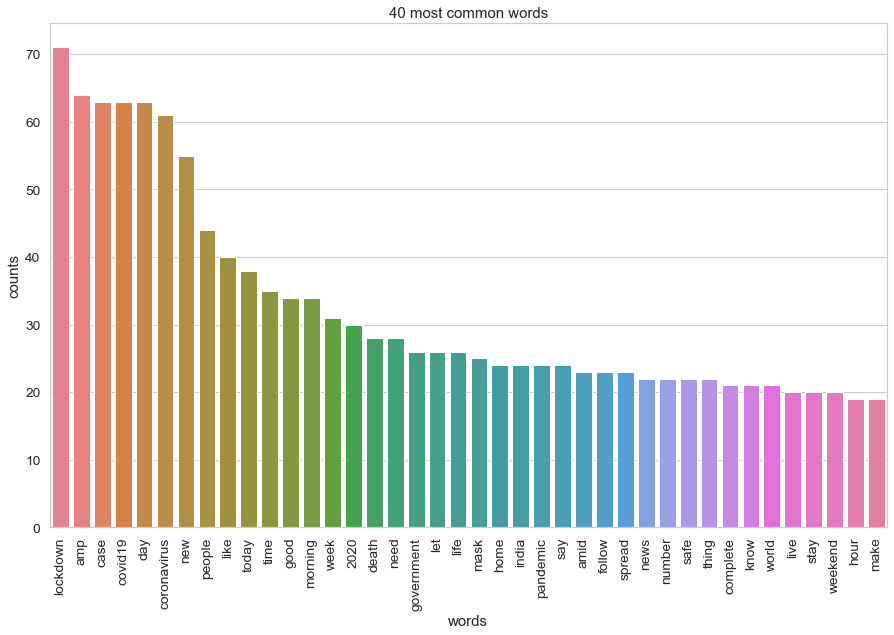

ValueError: operands could not be broadcast together with shapes (5233,) (3677,) (5233,) 

In [113]:
def plot_10_most_common_words(l_count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in l_count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:40]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='40 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Visualise the 10 most common words
plot_10_most_common_words(l_count_data, count_vectorizer)
plot_10_most_common_words(v_count_data, count_vectorizer)

In [116]:
#search hoax and fake in these tweets
def find_hoax(tweets_dataset):
    for i in range(len(tweets_dataset)):
        if 'hoax' in tweets_dataset['text'].iloc[i]:
            print(tweets_dataset['text'].iloc[i])
            tweets_dataset['count_hoax']=1
        else:
            tweets_dataset['count_hoax']=0

In [120]:
find_hoax(vaccine_tweets)
find_hoax(lockdown_tweets)

C:\Users\qiuxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['', 'might', 'seriously', 'be', 'the', 'biggest', 'hoax', 'of', 'all', 'time', 'wallahi', 'the', 'fear', 'mongering', 'coverups', 'and', 'misre', 'httpstcojz57aljrsn']


C:\Users\qiuxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [122]:
def find_fake(tweets_dataset):
    for i in range(len(tweets_dataset)):
        if 'fake' in tweets_dataset['text'].iloc[i]:
            print(tweets_dataset['text'].iloc[i])
            tweets_dataset['count_fake']=1
        else:
            tweets_dataset['count_fake']=0

In [127]:
find_fake(lockdown_tweets)
find_trump(lockdown_tweets)
find_mask(lockdown_tweets)

C:\Users\qiuxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\qiuxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['to', 'the', 'fools', 'who', 'still', 'believe', 'in', 'this', 'fake', 'pandemic', 'created', 'by', 'media', 'httpstcosdrfzouebs']
['trump', 'biden', 'httpstconurufmepyu']
['', 'gtheoriginal', 'if', 'trump', 'wins', 'all', 'the', 'absurdity', 'will', 'continue', 'if', 'biden', 'wins', 'it', 'w', 'httpstcooujfleswwm']
['wear', 'your', 'farken', 'mask', 'httpstcogbwk9acalz']
['be', 'safe', 'mask', 'up', 'httpstco3wxwtm95f7']
['new', 'mask', 'you', 'silly', 'humans', 'httpstco81rclvhezr', 'httpstcotiyqvxsqbd']
['i', 'went', 'out', 'today', 'amp', 'i', 'forgot', 'my', 'mask', 'httpstcojfryyh8cgp']
['new', 'mask', 'bang', 'httpstcoem6fw4bzx0', 'httpstcoiouseenryv']
['due', 'to', 'wore', 'a', 'mask', 'and', 'still', 'got', 'checked', 'out', 'today', 'clearly', 'it', 'wasnt', 'my', 'face', 'all', 'these', 'years', 'httpstcodjjtacaqyv']
['please', 'wear', 'a', 'mask', 'httpstco1nfqbfp4ms']
['lets', 'keep', 'these', 'things', 'in', 'mind', 'while', 'we', 'interact', 'always', 'wear', 'a', 'mas

In [126]:
def find_mask(tweets_dataset):
    for i in range(len(tweets_dataset)):
        if 'mask' in tweets_dataset['text'].iloc[i]:
            print(tweets_dataset['text'].iloc[i])

In [145]:
def find_china(tweets_dataset):
    for i in range(len(tweets_dataset)):
        if 'china' or 'chinese' in tweets_dataset['text'].iloc[i]:
            print(tweets_dataset['text'].iloc[i])

In [136]:
twitter_path='covid19_tweets.csv'
tweet = pd.read_csv(twitter_path)

In [144]:
from textblob import TextBlob
tweet['polarity']='to_be_determined'
tweet['sentiment']=None
for i in range(len(tweet)) :
    blob = TextBlob(tweet['text'].iloc[i])
    tweet['polarity'].iloc[i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        tweet['sentiment'].iloc[i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        tweet['sentiment'].iloc[i] = 'negative'
    else :
        tweet['sentiment'].iloc[i] = 'neutral'
tweet.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,polarity,sentiment
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,-0.25,negative
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0.5,positive
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,0,neutral
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,0,neutral
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,0,neutral


In [ ]:
#visualize the distribution of all sentiments

Text(0, 0.5, 'Frequency')

C:\Users\qiuxi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qiuxi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


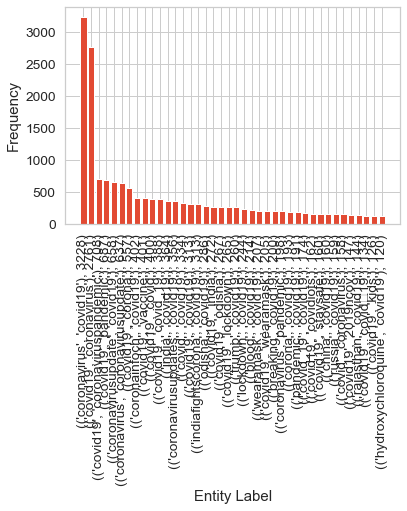

In [146]:
#import counter
from collections import Counter 
res=Counter(all_bigrams)
common = Counter(all_bigrams).most_common(40)
common
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)
#plt.bar(np.arange(nbars), number, tick_label=labels)
#plt.show()
label=common
label_counter = Counter()
#abel, count = zip(*label_counter.items())
plt.bar(range(len(label)), number)
plt.xticks(range(len(label)), label, rotation=90)
plt.xlabel('Entity Label')
plt.ylabel('Frequency')

In [12]:
# bigram trash codes
for i in range(len(more_than_one)):
    before_token= re.sub(r'[^\w\s]','',more_than_one['hashTagLower'].iloc[i])
    token=nltk.word_tokenize(before_token)
    more_than_one['hashtags_bigrams'].iloc[i] = list(ngrams(token, 2))
    #all_bigrams.append(list(ngrams(token, 2)))
all_bigrams=[]
for i in range(len(more_than_one)):
    #all_bigrams.append(list(ngrams(token, 2)))
    for f in range(len(more_than_one['hashtags_bigrams'].iloc[i])):
        temp_list=more_than_one['hashtags_bigrams'].iloc[i]
        append_bigram=temp_list[f]
        all_bigrams.append(append_bigram)
